In [ ]:
!pip install opendatasets

In [14]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria/download?datasetVersionNumber=1")

Skipping, found downloaded files in "./cell-images-for-detecting-malaria" (use force=True to force download)


In [15]:
import zipfile
import os

In [16]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [17]:
# Generate data paths with labels
data_dir = '/content/cell-images-for-detecting-malaria/cell_images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [19]:
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [20]:
df

,filepaths,labels
0,/content/cell-images-for-detecting-malaria/cel...,cell_images
1,/content/cell-images-for-detecting-malaria/cel...,cell_images
2,/content/cell-images-for-detecting-malaria/cel...,Parasitized
3,/content/cell-images-for-detecting-malaria/cel...,Parasitized
4,/content/cell-images-for-detecting-malaria/cel...,Parasitized
...,...,...
27557,/content/cell-images-for-detecting-malaria/cel...,Uninfected
27558,/content/cell-images-for-detecting-malaria/cel...,Uninfected
27559,/content/cell-images-for-detecting-malaria/cel...,Uninfected
27560,/content/cell-images-for-detecting-malaria/cel...,Uninfected


In [21]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [22]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 22046 validated image filenames belonging to 2 classes.
Found 3307 validated image filenames belonging to 2 classes.
Found 2205 validated image filenames belonging to 2 classes.


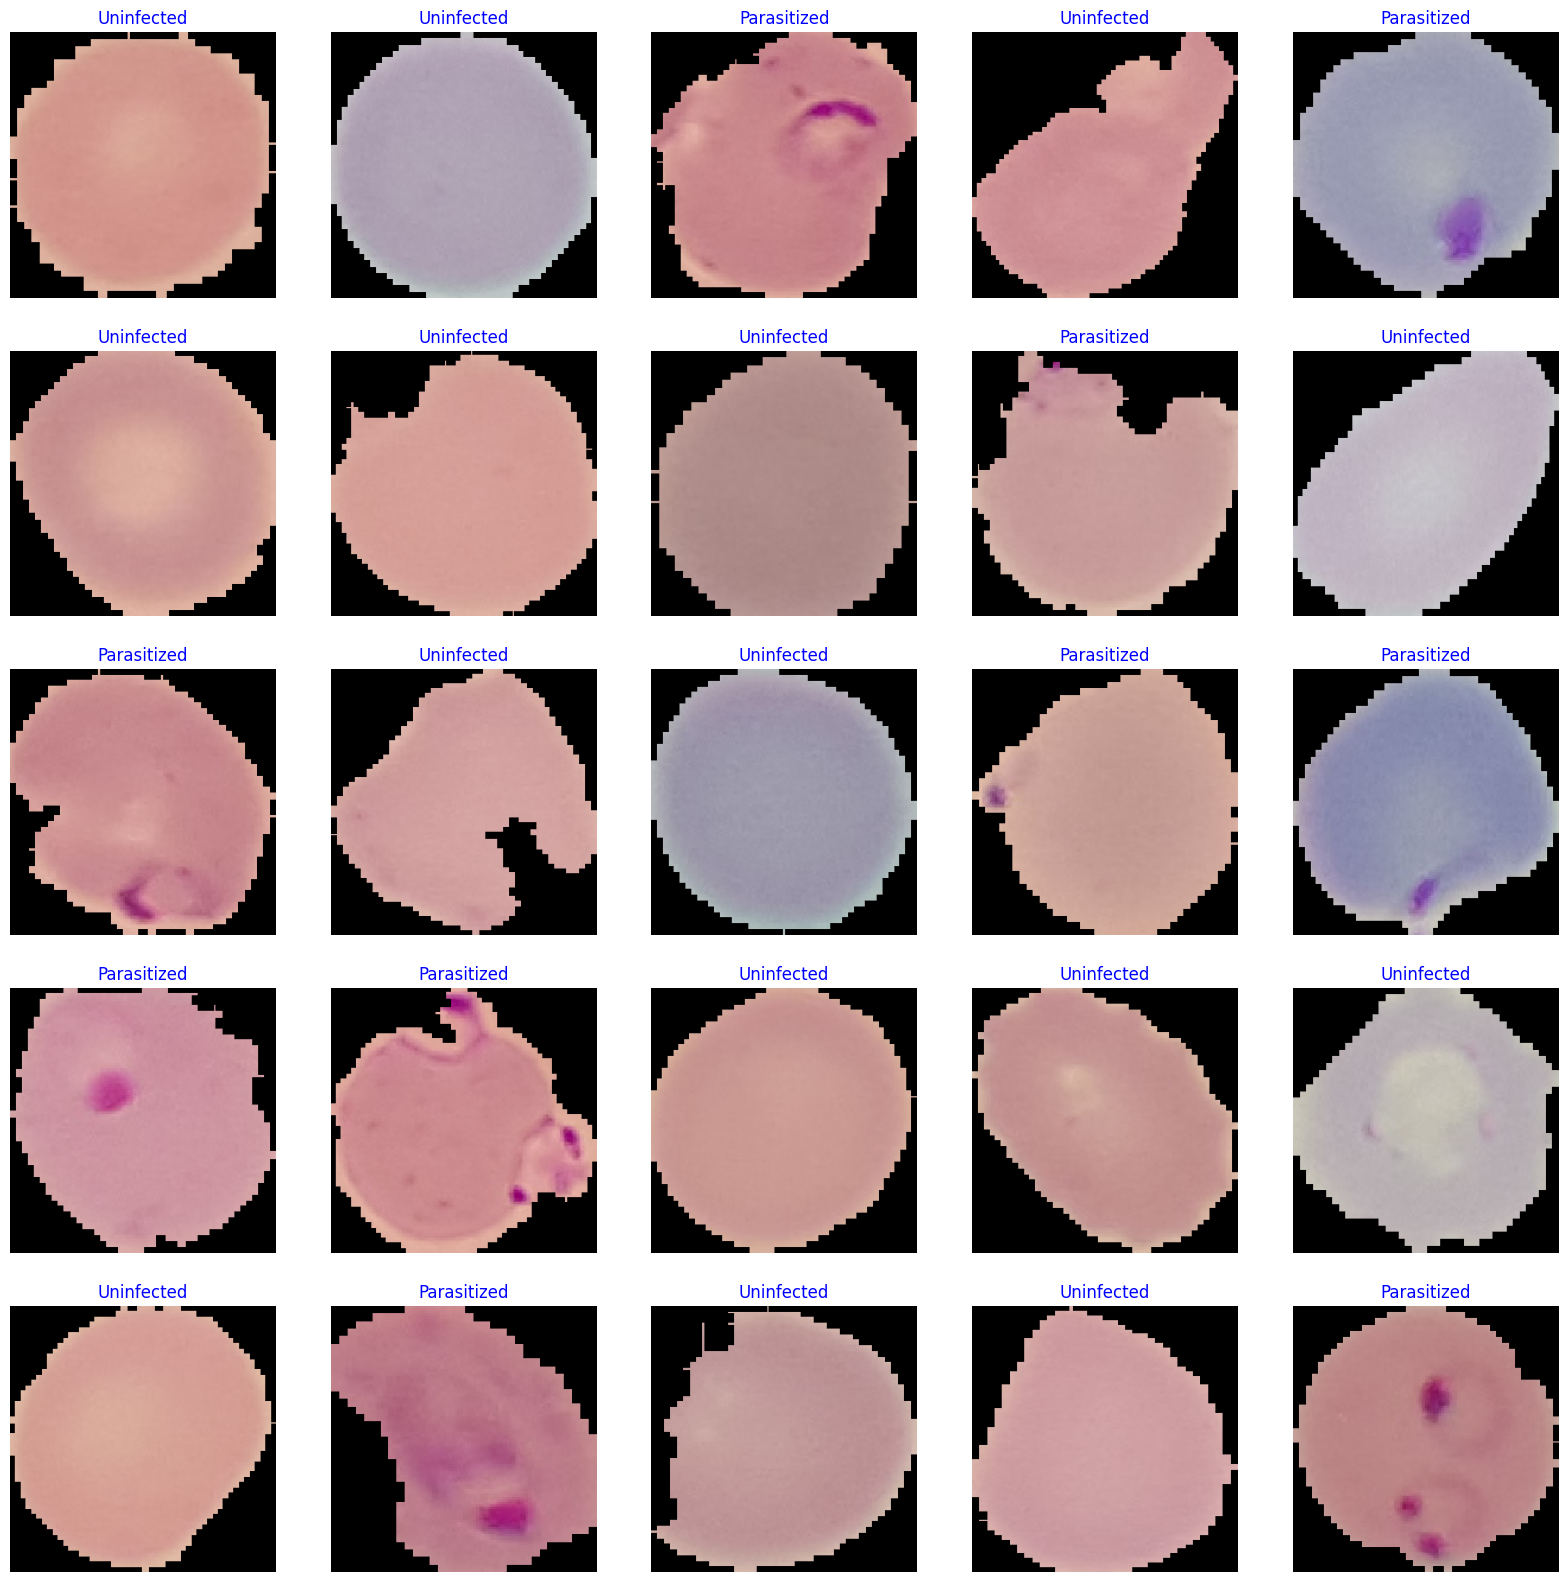

In [23]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [24]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define the number of classes in the dense layer

# create pre-trained model (you can use a pre-trained model such as MobileNetV3, VGG, ResNet)
# we will use MobileNetV3 in this case
base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 batch_normalization_1 (Bat  (None, 960)               3840      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               246016    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 3246722 (12.39 MB)
Trainable params: 322

In [25]:
epochs = 15   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/15
345/345 [==============================] - 121s 282ms/step - loss: 2.7374 - accuracy: 0.9522 - val_loss: 1.0622 - val_accuracy: 0.9531
Epoch 2/15
345/345 [==============================] - 96s 277ms/step - loss: 0.5910 - accuracy: 0.9691 - val_loss: 0.4312 - val_accuracy: 0.9380
Epoch 3/15
345/345 [==============================] - 95s 275ms/step - loss: 0.2517 - accuracy: 0.9752 - val_loss: 0.2238 - val_accuracy: 0.9646
Epoch 4/15
345/345 [==============================] - 95s 275ms/step - loss: 0.1597 - accuracy: 0.9825 - val_loss: 0.2344 - val_accuracy: 0.9438
Epoch 5/15
345/345 [==============================] - 95s 274ms/step - loss: 0.1210 - accuracy: 0.9874 - val_loss: 0.1692 - val_accuracy: 0.9622
Epoch 6/15
345/345 [==============================] - 94s 273ms/step - loss: 0.1007 - accuracy: 0.9908 - val_loss: 0.1543 - val_accuracy: 0.9661
Epoch 7/15
345/345 [==============================] - 95s 275ms/step - loss: 0.0809 - accuracy: 0.9948 - val_loss: 0.1566 - val_a

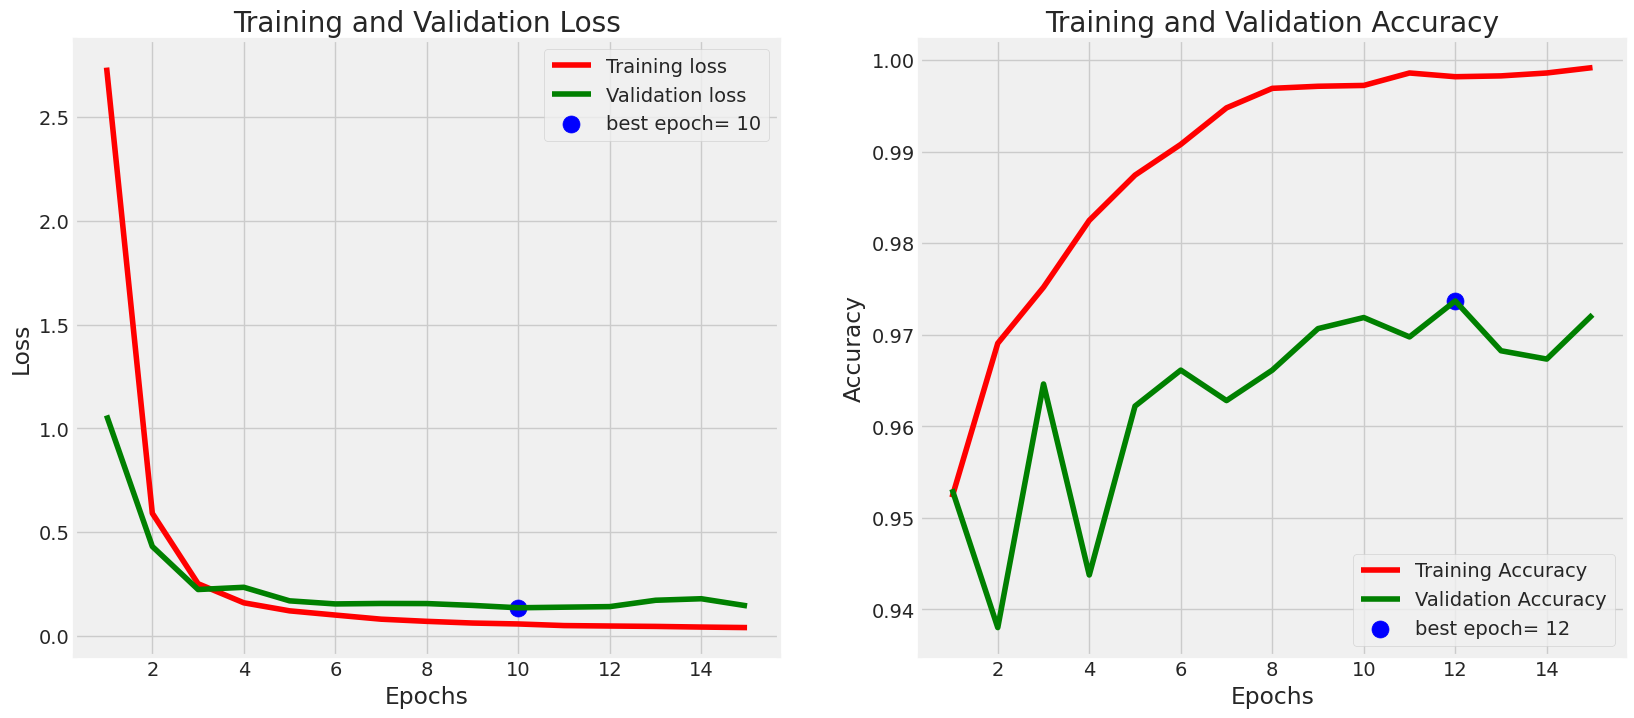

In [26]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [27]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 345/1103 [========>.....................] - ETA: 2:08 - loss: 0.0312 - accuracy: 1.0000

  52/1103 [>.............................] - ETA: 5:00 - loss: 0.1448 - accuracy: 0.9722

1103/1103 [==============================] - 15s 13ms/step - loss: 0.1712 - accuracy: 0.9669
Train Loss:  0.031178506091237068
Train Accuracy:  0.9999546408653259
--------------------
Validation Loss:  0.1448482722043991
Validation Accuracy:  0.9721802473068237
--------------------
Test Loss:  0.17118465900421143
Test Accuracy:  0.9668934345245361


In [28]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

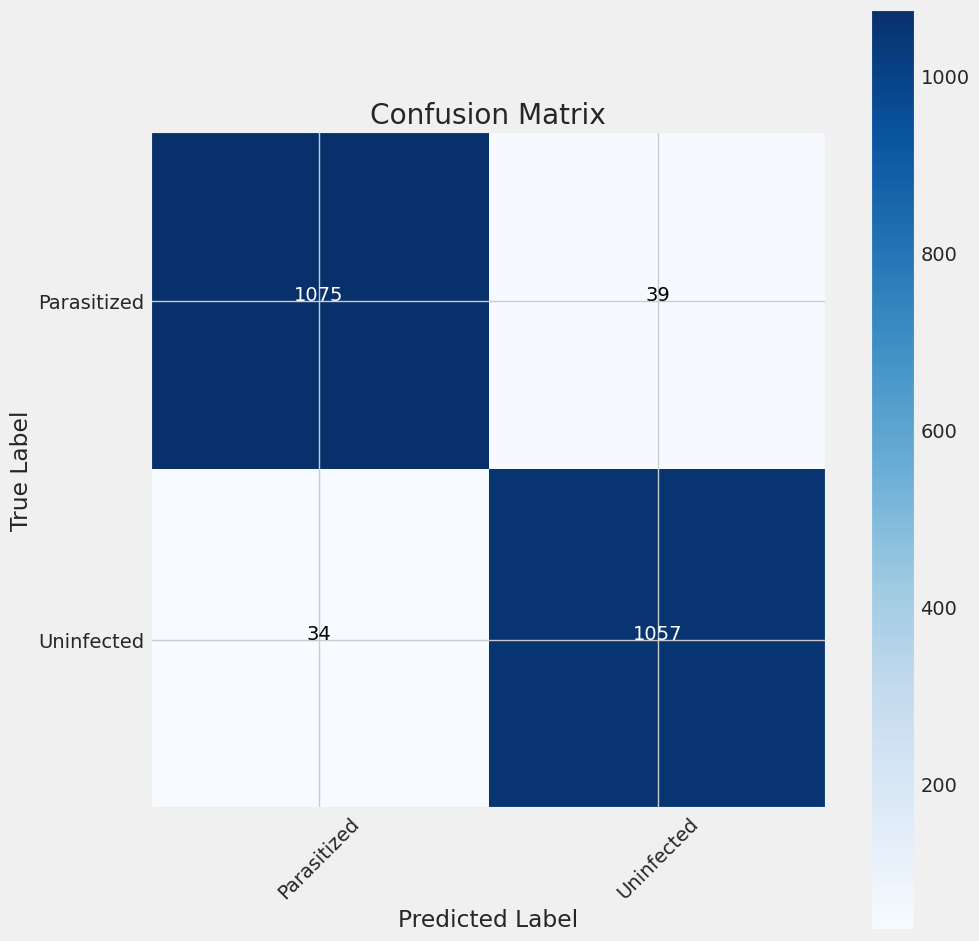

In [29]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [30]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

 Parasitized       0.97      0.96      0.97      1114
  Uninfected       0.96      0.97      0.97      1091

    accuracy                           0.97      2205
   macro avg       0.97      0.97      0.97      2205
weighted avg       0.97      0.97      0.97      2205



In [31]:
#Save the model
model.save('/content/cell-images-for-detecting-malaria/cell_images/Malaria_Cells.h5')

In [32]:
loaded_model = tf.keras.models.load_model('/content/cell-images-for-detecting-malaria/cell_images/Malaria_Cells.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
image_path = '/content/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 1s/step
Parasitized
